In [1]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
import scipy
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper
from mne.viz import plot_topomap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# set path to SpectralEvents
sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
import spectralevents as se

import pdb

In [2]:
def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def plot_features_scatter(x, y, responder_labels, ax_labels):
    '''Plot features across subjects in a 2D scatter plot.'''
    g = sns.JointGrid()

    for class_idx, class_ in enumerate(set(responder_labels)):
        if class_ == 1:
            label = 'responders'
        else:
            label = 'non-responders'
        cluster_mask = responder_labels == class_
        x_data = np.array(x)[cluster_mask]
        y_data = np.array(y)[cluster_mask]

        # plot data points for a given class label (i.e., responder or non-responder)
        sns.scatterplot(x=x_data, y=y_data, alpha=.5, edgecolor=None,
                        color=f'C{class_idx + 1}', ax=g.ax_joint)

        # plot marginal distributions for a given class label
        sns.kdeplot(x=x_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
        g.ax_marg_x.axvline(np.median(x_data), color=f'C{class_idx + 1}')
        sns.kdeplot(y=y_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_y)
        g.ax_marg_y.axhline(np.median(y_data), color=f'C{class_idx + 1}')

    g.ax_joint.set_xlabel(ax_labels[0])
    g.ax_joint.set_ylabel(ax_labels[1])
    g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    g.fig.tight_layout()

In [3]:
def cross_spectral_decomp(event_windows, lag):
    n_events = event_windows.shape[0]
    n_chans = event_windows.shape[1]
    n_samps = event_windows.shape[2]
    
    # split win in half
    comp_1 = list()
    half_idx = n_samps // 2
    for win_range in range(2):
        c_mat_agg = np.zeros((n_events, n_chans, n_chans))
        for event_idx, event_window in enumerate(event_windows):
            c_mat = np.zeros((n_chans, n_chans))
            for chan1_idx, chan1_timeseries in enumerate(event_window):
                for chan2_idx, chan2_timeseries in enumerate(event_window):
                    if win_range == 0:
                        x = scipy.stats.zscore(chan1_timeseries[:half_idx])
                        y = scipy.stats.zscore(chan2_timeseries[:half_idx])
                    else:
                        x = scipy.stats.zscore(chan1_timeseries[half_idx:])
                        y = scipy.stats.zscore(chan2_timeseries[half_idx:])
                    # calc the cross-correlation at the freq of interest
                    xcorr = np.sum(x[lag:] * y[:len(y) - lag])
                    c_mat[chan1_idx, chan2_idx] = xcorr
            c_mat = (c_mat + c_mat.T) / 2
            c_mat_agg[event_idx, :, :] = c_mat
        U, s, Vh = np.linalg.svd(c_mat_agg.mean(axis=0))
        comp_1.append(Vh[0])

    return comp_1[0], comp_1[1]


def spec_spat_events(epochs_pre_post, times):
    event_band = [9, 14]  # alpha band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    t_win = 0.6  # time window; 100 ms
    n_win_samps = int((t_win / 2) // dt)
    #t_win_times = np.arange(0, t_win / 2 + dt, dt)
    #t_win_times = np.r_[-t_win_times[-1:0:-1], t_win_times[:]]
    iei_min = 0.6  # minimum distance between global spectral events (>=t_win); 300 ms
    
    sess_event_rate = list()
    sess_event_avg_freq = list()
    sess_event_topo = list()
    sess_event_comp_change = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_channels = epochs_data.shape[1]
        n_times = epochs_data.shape[2]
        
        # z-score data across channels and time
        epochs_data -= epochs_data.mean(axis=(1, 2), keepdims=True)
        epochs_data /= epochs_data.std(axis=(1, 2), keepdims=True)
        
        # z-score data across time (caution: removes some spatial patterns!)
        #epochs_data -= epochs_data.mean(axis=(2,), keepdims=True)
        #epochs_data /= epochs_data.std(axis=(2,), keepdims=True)
        
        tfrs_chan_avg = np.zeros((n_epochs, len(freqs), n_times))
        for epoch_idx, epoch_data in enumerate(epochs_data):
            tfrs = se.tfr(epoch_data, freqs, samp_freq)
            # average TFR for this epoch across all channels
            tfrs_chan_avg[epoch_idx, :, :] = np.mean(tfrs, axis=(0,))
        
        # spectral events need to be found using a common thresh procedure across epochs
        spec_events_global = se.find_events(tfr=tfrs_chan_avg, times=times, freqs=freqs,
                                            event_band=event_band, threshold_FOM=3.5)

        # sanity check: plot "global" events for the 1st epoch
        #fig = se.plot_events(tfr=tfrs_chan_avg[0, :, :],
        #                     times=times,
        #                     freqs=freqs,
        #                     event_band=event_band,
        #                     spec_events=spec_events_global[0])

        print(f'Found {len(sum(spec_events_global, []))} global spectral events!!!')
        
        event_freqs = list()
        event_windows_agg = list()
        for epoch_events, epoch_data in zip(spec_events_global, epochs_data):

            event_times = np.array([event['Peak Time'] for event in epoch_events])

            event_times_no_overlap = list()
            for event_idx, event_time in enumerate(event_times):
                # crop off events that are too close to the beginning/end of epoch
                if (event_time - (n_win_samps * dt) < times[0] or
                    event_time + (n_win_samps * dt) > times[-1]):
                    continue
                    
                # don't include events that are shortly followed by another subsequent event
                
                if event_idx + 1 < len(event_times):
                    next_event_time = event_times[event_idx + 1]
                    if next_event_time - event_time < iei_min:
                        continue
                    
                event_times_no_overlap.append(event_time)

            if len(event_times_no_overlap) > 0:
                # get event peak frequencies to calculate average lag; concat to master list
                event_freqs += [event['Peak Frequency'] for event in epoch_events
                                if event['Peak Time'] in event_times_no_overlap]

                # capture the timecourse window at the current event across channels
                event_windows = np.zeros((len(event_times_no_overlap), n_channels, n_win_samps * 2 + 1))
                for event_idx, event_time in enumerate(event_times_no_overlap):
                    event_time_idx = np.nonzero(times == event_time)[0][0]
                    begin_idx = event_time_idx - n_win_samps
                    end_idx = event_time_idx + n_win_samps + 1
                    event_windows[event_idx, :, :] = epoch_data[:, begin_idx:end_idx]

                # append to aggregate list of events across all epochs in this session
                event_windows_agg.append(event_windows)
        
        event_rate = len(sum(spec_events_global, [])) / n_epochs
        
        # master array of all event windows across epochs
        event_windows_agg = np.concatenate(event_windows_agg)
        print(f'Kept {event_windows_agg.shape[0]} events for analysis!!!')
        print(f'shape: {event_windows_agg.shape}')
        
        if event_windows_agg.shape[0] == 0:
            raise ValueError("No events were found in this session. Consider decreasing "
                             "threshold_FOM when searching for spectral events!!!")
        
        # calculate lag as the time period associated with the avg peak frequency across events
        peak_freq_avg = np.mean(event_freqs)
        lag = int(round(samp_freq / peak_freq_avg))  # time lag in number of samples (i.e., indices)

        cs_comp1, cs_comp2 = cross_spectral_decomp(event_windows_agg, lag)
        cs_comp_change = np.linalg.norm(cs_comp2 - cs_comp1)
        
        # compile session stats
        sess_event_rate.append(event_rate)
        sess_event_avg_freq.append(peak_freq_avg)
        sess_event_topo.append([cs_comp1, cs_comp2])
        sess_event_comp_change.append(cs_comp_change)
        
    event_rate_diff = sess_event_rate[1] - sess_event_rate[0]
    sess_event_avg_freq_diff = sess_event_avg_freq[1] - sess_event_avg_freq[0]
    sess_event_comp_change_diff = sess_event_comp_change[1] - sess_event_comp_change[0]
    cs_comp_std_change = sess_event_topo[0][0].std() - sess_event_topo[1][0].std()

    return (event_rate_diff, sess_event_avg_freq_diff,
            sess_event_comp_change_diff, cs_comp_std_change,
            sess_event_topo)


def get_features(subj_id, series_num, data_dir):
    '''Main pipeline for computing all features for a given subject.'''
    epochs_pre_post, _, times = read_data(subj_id, series_num, data_dir)
    features = spec_spat_events(epochs_pre_post, times)
    return features

In [4]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [5]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_subj_series = sum(subj_select)

In [6]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
symptoms_init = outcome_info['IDSSRtot.Ses1'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

## Optional: pipeline test

In [44]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
spec_spat_features = get_features(subj_ids[0], series_nums[0], data_type_dir)

# plot two successive post-event topographies in the pre-TMS session
_, epochs_info, _ = read_data(subj_ids[0], series_nums[0], data_type_dir)
fig, axes = plt.subplots(1, 2)
im_1, _ = plot_topomap(spec_spat_features[4][0][0], epochs_info, axes=axes[0],
                       vmin=-0.2, vmax=0.2, show=False)
plt.colorbar(im_1, ax=axes[0], fraction=0.05)
im_2, _ = plot_topomap(spec_spat_features[4][0][1], epochs_info, axes=axes[1],
                       vmin=-0.2, vmax=0.2, show=True)
plt.colorbar(im_2, ax=axes[1], fraction=0.05)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_48050/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_48050/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 278 global spectral events!!!
Kept 140 events for analysis!!!
shape: (140, 64, 299)


KeyboardInterrupt: 

## Run main pipeline for feature extraction

In [7]:
# run spatio-spectral alpha coherence feature extraction
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 32
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_subj_series))
feat_1, feat_2, feat_3, feat_4, topos = zip(*out)

# convert to numpy arrays
feat_1 = np.array(feat_1)
feat_2 = np.array(feat_2)
feat_3 = np.array(feat_3)
feat_4 = np.array(feat_4)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0091_Pre_Session1_Series4_Preprocessed.set...
Not setting metadata
80 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0116_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
75 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0249_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T2/preprocessed/0091_Post_Session1_Series4_Preprocessed.set...
Extracting parameters from /gpfs/data/brai

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0274_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
No baseline correction applied
Ready.
0 projection items activated
Ready.
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0293_Post_Session1_Series2_Preprocessed.set...
Ready.
Not setting metadata
42 matching events found
Not setting metadata
74 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0313_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
Not setting metadata
81 matching events found
117 matching events found
No baseline correction applied
0 projectio

Found 43 global spectral events!!!
Kept 28 events for analysis!!!
shape: (28, 64, 299)
Found 41 global spectral events!!!
Kept 34 events for analysis!!!
shape: (34, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0348_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0346_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
114 matching events found
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0348_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 27 global spectral events!!!
Kept 21 events for analysis!!!
shape:

Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 109 global spectral events!!!
Kept 74 events for analysis!!!
shape: (74, 64, 299)
Found 92 global spectral events!!!
Kept 57 events for analysis!!!
shape: (57, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0370_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0370_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 138 global spectral events!!!
Kept 76 events for analysis!!!
shape: (76, 64, 299)
Found 132 global spectral events!!!
Kept 73 events for analysis!!!
shape: (73, 64, 299)
Extracting parameters from /gpfs/d

Found 203 global spectral events!!!
Kept 107 events for analysis!!!
shape: (107, 64, 299)
Found 236 global spectral events!!!
Kept 120 events for analysis!!!
shape: (120, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0392_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0392_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 216 global spectral events!!!
Kept 114 events for analysis!!!
shape: (114, 64, 299)
Found 182 global spectral events!!!
Kept 104 events for analysis!!!
shape: (104, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0401_Pre_Session1_Series1_Preprocessed.set...
No

No baseline correction applied
0 projection items activated
Ready.
Found 23 global spectral events!!!
Kept 18 events for analysis!!!
shape: (18, 64, 299)
Found 18 global spectral events!!!
Kept 13 events for analysis!!!
shape: (13, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0421_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0421_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 103 global spectral events!!!
Kept 49 events for analysis!!!
shape: (49, 64, 299)
Found 93 global spectral events!!!
Kept 68 events for analysis!!!
shape: (68, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/prepr

No baseline correction applied
0 projection items activated
Ready.
Found 69 global spectral events!!!
Kept 48 events for analysis!!!
shape: (48, 64, 299)
Found 79 global spectral events!!!
Kept 55 events for analysis!!!
shape: (55, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0469_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0469_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 176 global spectral events!!!
Kept 98 events for analysis!!!
shape: (98, 64, 299)
Found 197 global spectral events!!!
Kept 115 events for analysis!!!
shape: (115, 64, 299)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/pr

/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 121 global spectral events!!!
Kept 65 events for analysis!!!
shape: (65, 64, 299)
Found 100 global spectral events!!!
Kept 57 events for analysis!!!
shape: (57, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 103 global spectral events!!!
Kept 77 events for analysis!!!
shape: (77, 64, 299)
Found 97 global spectral events!!!
Kept 72 events for analysis!!!
shape: (72, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 123 global spectral events!!!
Kept 66 events for analysis!!!
shape: (66, 64, 299)
Found 78 global spectral events!!!
Kept 49 events for analysis!!!
shape: (49, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 63 global spectral events!!!
Kept 47 events for analysis!!!
shape: (47, 64, 299)
Found 100 global spectral events!!!
Kept 67 events for analysis!!!
shape: (67, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 60 global spectral events!!!
Kept 40 events for analysis!!!
shape: (40, 64, 299)
Found 57 global spectral events!!!
Kept 30 events for analysis!!!
shape: (30, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 202 global spectral events!!!
Kept 95 events for analysis!!!
shape: (95, 64, 299)
Found 205 global spectral events!!!
Kept 106 events for analysis!!!
shape: (106, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 51 global spectral events!!!
Kept 42 events for analysis!!!
shape: (42, 64, 299)
Found 52 global spectral events!!!
Kept 37 events for analysis!!!
shape: (37, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 170 global spectral events!!!
Kept 88 events for analysis!!!
shape: (88, 64, 299)
Found 124 global spectral events!!!
Kept 83 events for analysis!!!
shape: (83, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 48 global spectral events!!!
Kept 44 events for analysis!!!
shape: (44, 64, 299)
Found 228 global spectral events!!!
Kept 135 events for analysis!!!
shape: (135, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 180 global spectral events!!!
Kept 92 events for analysis!!!
shape: (92, 64, 299)
Found 111 global spectral events!!!
Kept 66 events for analysis!!!
shape: (66, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 29 global spectral events!!!
Kept 23 events for analysis!!!
shape: (23, 64, 299)
Found 27 global spectral events!!!
Kept 21 events for analysis!!!
shape: (21, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 113 global spectral events!!!
Kept 77 events for analysis!!!
shape: (77, 64, 299)
Found 64 global spectral events!!!
Kept 50 events for analysis!!!
shape: (50, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 150 global spectral events!!!
Kept 91 events for analysis!!!
shape: (91, 64, 299)
Found 144 global spectral events!!!
Kept 79 events for analysis!!!
shape: (79, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 13 global spectral events!!!
Kept 12 events for analysis!!!
shape: (12, 64, 299)
Found 25 global spectral events!!!
Kept 19 events for analysis!!!
shape: (19, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 41 global spectral events!!!
Kept 30 events for analysis!!!
shape: (30, 64, 299)
Found 20 global spectral events!!!
Kept 15 events for analysis!!!
shape: (15, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 95 global spectral events!!!
Kept 63 events for analysis!!!
shape: (63, 64, 299)
Found 143 global spectral events!!!
Kept 72 events for analysis!!!
shape: (72, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 214 global spectral events!!!
Kept 85 events for analysis!!!
shape: (85, 64, 299)
Found 117 global spectral events!!!
Kept 68 events for analysis!!!
shape: (68, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 42 global spectral events!!!
Kept 38 events for analysis!!!
shape: (38, 64, 299)
Found 16 global spectral events!!!
Kept 15 events for analysis!!!
shape: (15, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

## Try to visualize clusters and observe trends

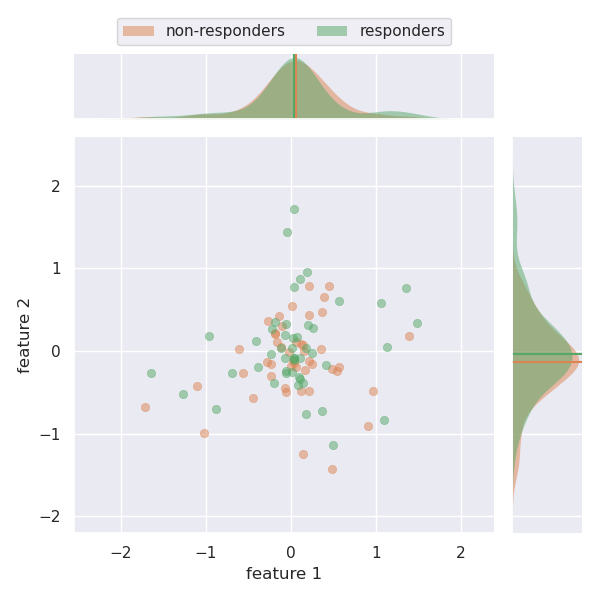

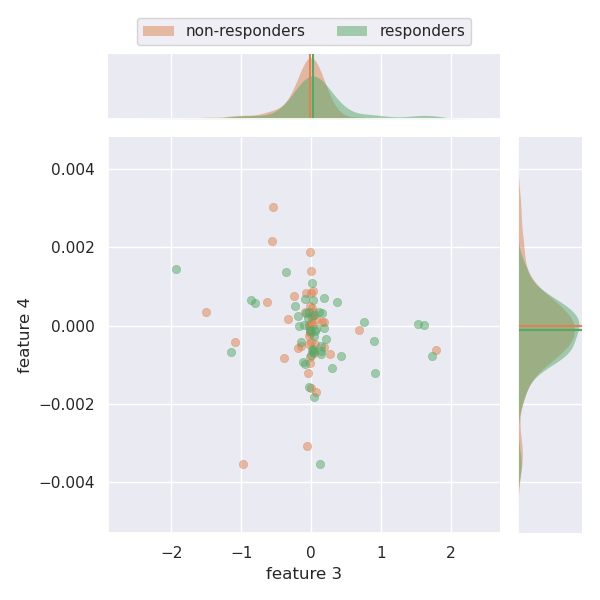

In [8]:
# plot 1st and 2nd features
#ax_labels = [r'$std(W_{sess_2})-std(W_{sess_1})$', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 1', 'feature 2']
plot_features_scatter(x=feat_1, y=feat_2, responder_labels=responders, ax_labels=ax_labels)

# plot 1st and 3rd features
#ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 3', 'feature 4']
plot_features_scatter(x=feat_3, y=feat_4, responder_labels=responders, ax_labels=ax_labels)

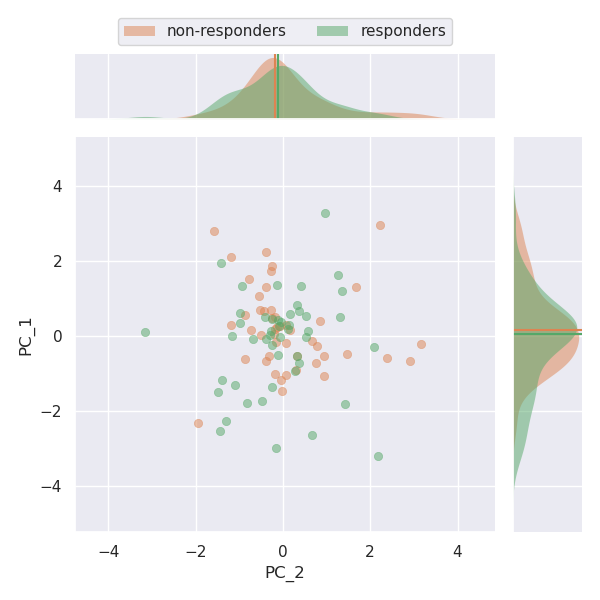

In [10]:
# PCA: see if the two data classes appear to be linearly separable
# answer: nope
X = np.c_[feat_1, feat_2, feat_3, feat_4]
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
pcs = pca.components_[:2, :]
X_pc = X @ pcs.T

ax_labels = ['PC_2', 'PC_1']
plot_features_scatter(x=X_pc[:, 1], y=X_pc[:, 0], responder_labels=responders, ax_labels=ax_labels)

## Train and validate SVM classifier
- first try omicient version (i.e., training data = testing data)
- then try with separate training and testing datasets, for demographic regressors only
- finally add EEG features

In [11]:
X = np.c_[feat_1, feat_2, feat_3, feat_4, ages, sexes, depression_histories, symptoms_init]
X = StandardScaler().fit_transform(X)
svm_cls = svm.SVC(kernel='rbf')
svm_cls.fit(X, responders)
svm_cls.score(X, responders)

0.8

Found 27 global spectral events!!!
Kept 22 events for analysis!!!
shape: (22, 64, 299)
Found 138 global spectral events!!!
Kept 80 events for analysis!!!
shape: (80, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 60 global spectral events!!!
Kept 46 events for analysis!!!
shape: (46, 64, 299)
Found 142 global spectral events!!!
Kept 73 events for analysis!!!
shape: (73, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 158 global spectral events!!!
Kept 91 events for analysis!!!
shape: (91, 64, 299)
Found 164 global spectral events!!!
Kept 86 events for analysis!!!
shape: (86, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


In [12]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(training_set_ratio * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='rbf')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.5024137931034482


In [15]:
n_perm = 1000
training_set_ratio = 0.8

n_set = n_subj_series
n_training_set = int(np.round(training_set_ratio * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[feat_1[train_idxs],
                    feat_2[train_idxs],
                    feat_3[train_idxs],
                    feat_4[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='linear')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[feat_1[test_idxs],
                   feat_2[test_idxs],
                   feat_3[test_idxs],
                   feat_4[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.45626315789473687
Found 217 global spectral events!!!
Kept 105 events for analysis!!!
shape: (105, 64, 299)
Found 203 global spectral events!!!
Kept 105 events for analysis!!!
shape: (105, 64, 299)
Found 156 global spectral events!!!
Kept 99 events for analysis!!!
shape: (99, 64, 299)
Found 137 global spectral events!!!
Kept 83 events for analysis!!!
shape: (83, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f